#  COM-304. Reiforcement Learning Notebook

The main goal of this notebook is to demonstrate how to use Habitat-Sim simulator and Habitat-Lab library for trianing agents. You will evaluate a pre-trained agent that uses visual observations for navigation and implement a Policy Gradient (REINFORCE) algorithm to train a simple blind agent that uses only GPS+Compass sensors for navigation. This notebook achieves best performance in training and evaluation with GPUs. However, it is possible to run it on CPU, but it will be much slower.

There are two types of exercises in this notebook:
1. Coding exercise -- you will need to implement some missing parts of the code. You will recognize them by `TODO:` comments.
2. Questions -- you will need to analyse results and unswer an open-ended question in text . There are N of them. You will recognize them by `Question (X points)` title. **Be concise in your answers.**

# Setup

In [1]:
%pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.6 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 86.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 6.0 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import seaborn as sns
import matplotlib
matplotlib.rcParams["figure.dpi"] = 100
sns.set_style("whitegrid")


# Introduction to Habitat
There are two important components of Habitat:
1. [Habitat-Sim](https://github.com/facebookresearch/habitat-sim), a simulator with photo-realistic rendering and rigid-body mechanics,
2. [Habitat-Lab](https://github.com/facebookresearch/habitat-lab), a modular high-level library for end-to-end development in embodied AI.

There are also [challenges](https://aihabitat.org/challenge/2023/) in Habitat for various tasks, such as PointGoal Navigation, ObjectGoal Navigation, etc.

# Build our first environment
Let's first build our environment with Habitat-Sim. There are three important components in Habitat-Sim:
1. multiple sensors
2. configurable embodied agents
3. scenes that can be loaded from various datasets, such as [Gibson](http://gibsonenv.stanford.edu/database/), [Matterport3D](https://niessner.github.io/Matterport/), [Habitat Matterport 3D](https://aihabitat.org/datasets/hm3d/), etc.

Thus, to create an simulation environment, we need to specify the configuration for the sensors, agent, and simulator backend (including the scene).

## Imports
We import some packages that will be used later.

In [3]:
import random

from PIL import Image
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import habitat_sim

## Sensor configuration
First, let's configure the sensors. Here we use one RGB sensor and one depth sensor. We can customize many properties about the sensors, such as spatial resolution, position, rotation, etc.

In [7]:
sensor_settings = {
    "height": 256, "width": 256,  # Spatial resolution of observations
    "sensor_height": 1.5,  # Height of sensors in meters, relative to the agent
}

# Create a RGB sensor configuration
rgb_sensor_spec = habitat_sim.CameraSensorSpec()
rgb_sensor_spec.uuid = "color_sensor"
rgb_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
rgb_sensor_spec.resolution = [sensor_settings["height"], sensor_settings["width"]]
rgb_sensor_spec.position = [0.0, sensor_settings["sensor_height"], 0.0]
rgb_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE

# Create a depth sensor configuration
depth_sensor_spec = habitat_sim.CameraSensorSpec()
depth_sensor_spec.uuid = "depth_sensor"
depth_sensor_spec.sensor_type = habitat_sim.SensorType.DEPTH
depth_sensor_spec.resolution = [sensor_settings["height"], sensor_settings["width"]]
depth_sensor_spec.position = [0.0, sensor_settings["sensor_height"], 0.0]
depth_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE

sensor_specs = [rgb_sensor_spec, depth_sensor_spec]

***Comment on the depth sensor:** while we directly pass the depth infromation to the agent, it can still be (approximately) derrived from the RGB signal via binocular vision or various depth cues. Therefore, we still treat this signal as visual.* 

## Agent configuration
Next, we configure the agent. Here, we specify the action space of the agent, such as the distance to move and angle to turn.

Note that the sensor configurations are contained in the agent configuration since the sensors are rigidly attached to the agent.

In [8]:
agent_settings = {
    "action_space": {
        "move_forward": 0.25, "move_backward": 0.25,  # Distance to cover in a move action in meters
        "turn_left": 30.0, "turn_right": 30,  # Angles to cover in a turn action in degrees
    }
}

# Create an agent configuration
agent_cfg = habitat_sim.agent.AgentConfiguration()
agent_cfg.action_space = {
    k: habitat_sim.agent.ActionSpec(
        k, habitat_sim.agent.ActuationSpec(amount=v)
    ) for k, v in agent_settings["action_space"].items()
}
agent_cfg.sensor_specifications = sensor_specs

## Simulator backend configuration
Finally, we configure the simulator backend, such as the scene we want to use and whether to enable the physics.

In [9]:
sim_settings = {
    "default_agent": 0,  # Index of the default agent
    "scene_id": "data/scene_datasets/gibson/Cantwell.glb",  # Scene file, episode 0 in val split of Gibson
    "enable_physics": False,  # kinematics only
    "seed": 42  # used in the random navigation
}

# Create a simulator backend configuration
sim_cfg = habitat_sim.SimulatorConfiguration()
sim_cfg.scene_id = sim_settings["scene_id"]
sim_cfg.enable_physics = sim_settings["enable_physics"]

## Configuration for the simulator
Let's collect our configurations for the sensors, agent, and simulator backend into a configuration that can be understood by the simulator.

In [10]:
# Create a configuration for the simulator
cfg = habitat_sim.Configuration(sim_cfg, [agent_cfg])

## Create a simulator instance
We build a simulator based on the configuration

In [11]:
try:
    sim.close()
except NameError:
    pass
sim = habitat_sim.Simulator(cfg)

[20:42:01:832660]:[Metadata] AttributesManagerBase.h(380)::createFromJsonOrDefaultInternal : <Dataset>: Proposing JSON name : default.scene_dataset_config.json from original name : default| This file does not exist.
[20:42:01:832902]:[Metadata] AssetAttributesManager.cpp(123)::createObject : Asset attributes (capsule3DSolid:capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
[20:42:01:833031]:[Metadata] AssetAttributesManager.cpp(123)::createObject : Asset attributes (capsule3DWireframe:capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and registered.
[20:42:01:833090]:[Metadata] AssetAttributesManager.cpp(123)::createObject : Asset attributes (coneSolid:coneSolid_segments_12_halfLen_1.25_rings_1_useTexCoords_false_useTangents_false_capEnd_true) created and registered.
[20:42:01:833129]:[Metadata] AssetAttributesManager.cpp(123)::createObject : Asset attributes (coneWireframe:coneWireframe_s

[20:42:02:437324]:[Assets] ResourceManager.cpp(355)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SceneInstanceAttributes-provided name : data/scene_datasets/gibson/Cantwell.scn  nor constructed filename : data/scene_datasets/gibson/info_semantic.json exist on disk.
[20:42:05:648573]:[Sim] Simulator.cpp(474)::instanceStageForSceneAttributes : 
---
The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0  
---


## Manual navigation
Let's navigate the agent in the scene and check what it sees.

We declare some utility functions for displaying the observations received by the agent.

In [12]:
# Randomness is needed when choosing the actions
random.seed(sim_settings["seed"])
sim.seed(sim_settings["seed"])

# A utility function for displaying observations
def display_obs(rgb_obs: np.ndarray, depth_obs: np.ndarray):
    img_arr, title_arr = [], []
    
    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")
    img_arr.append(rgb_img)
    title_arr.append("rgb")
    
    depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
    img_arr.append(depth_img)
    title_arr.append("depth")
    
    plt.figure(figsize=(12, 8))
    for i, (img, title) in enumerate(zip(img_arr, title_arr)):
        ax = plt.subplot(1, 2, i + 1)
        ax.axis("off")
        ax.set_title(title)
        plt.imshow(img)
    plt.show(block=False)

We first put the agent into a position we like, say, `[-4.69643, 0.15825, -2.90618]`.

In [13]:
# Set agent state
agent = sim.initialize_agent(sim_settings["default_agent"])  # Get our default agent
agent_state = habitat_sim.AgentState()
agent_state.position = np.array([-4.69643, 0.15825, -2.90618])  # Position in world coordinate
agent.set_state(agent_state)

# Get agent state
agent_state = agent.get_state()
print(f"Agent state: position ({agent_state.position}), rotation ({agent_state.rotation})")

Agent state: position ([-4.69643  0.15825 -2.90618]), rotation (quaternion(1, 0, 0, 0))


You can control the agent to `move_forward`, `move_backward`, `turn_left`, or `turn_right` by `T`, `G`, `F`, or `H`, respectively. If you do not want to continue, just press `O`.

__TODO: CODING EXERCISE BELOW (10pts)__

Use TGFH to control the agent now:  t


Choose to move_forward


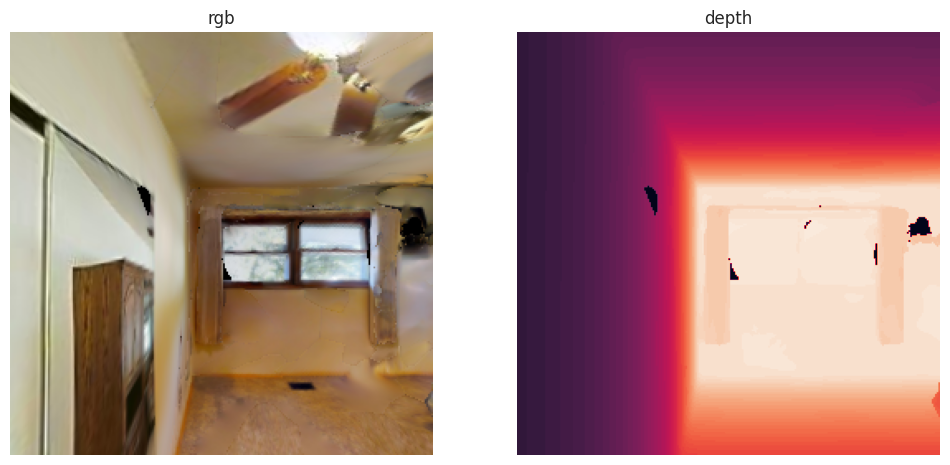

Use TGFH to control the agent now:  h


Choose to turn_right


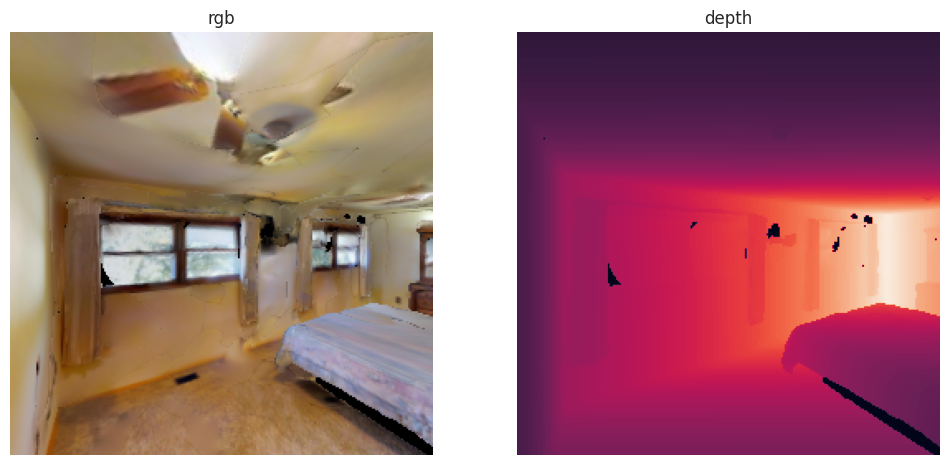

Use TGFH to control the agent now:  h


Choose to turn_right


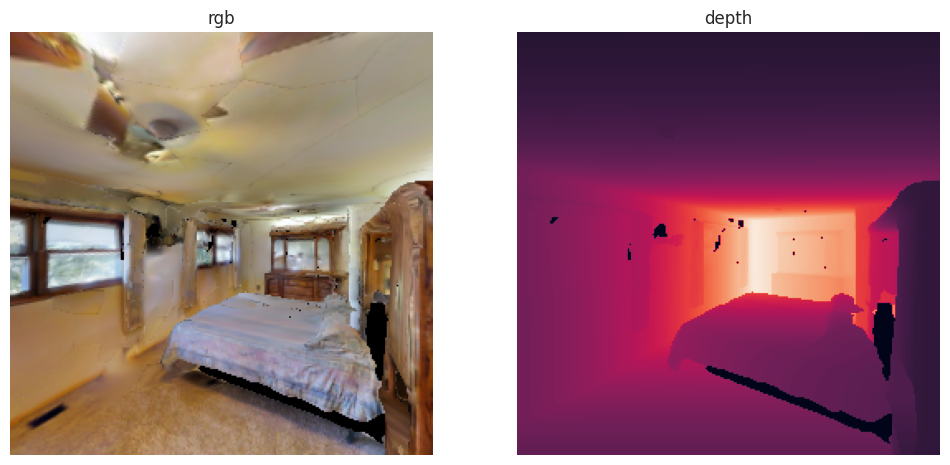

Use TGFH to control the agent now:  t


Choose to move_forward


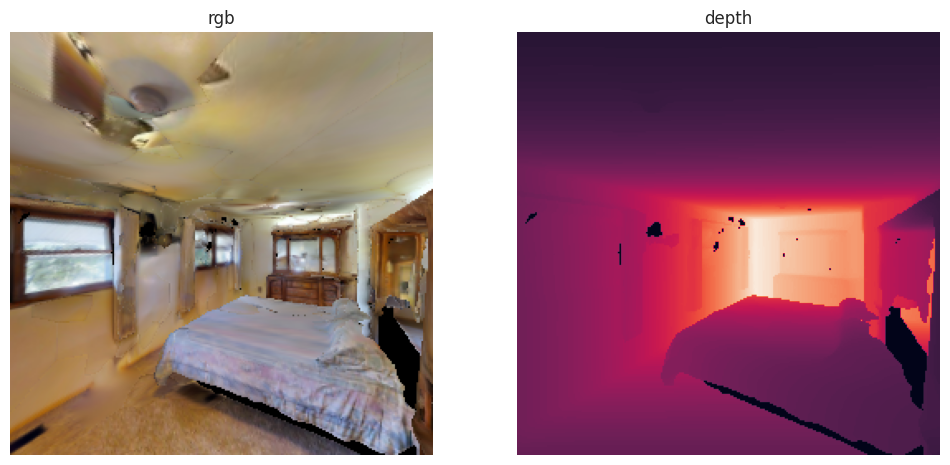

Use TGFH to control the agent now:  h


Choose to turn_right


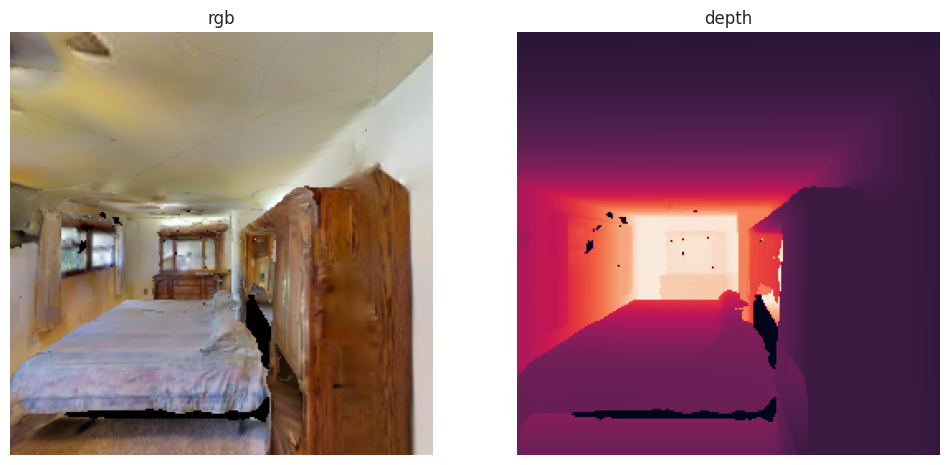

Use TGFH to control the agent now:  h


Choose to turn_right


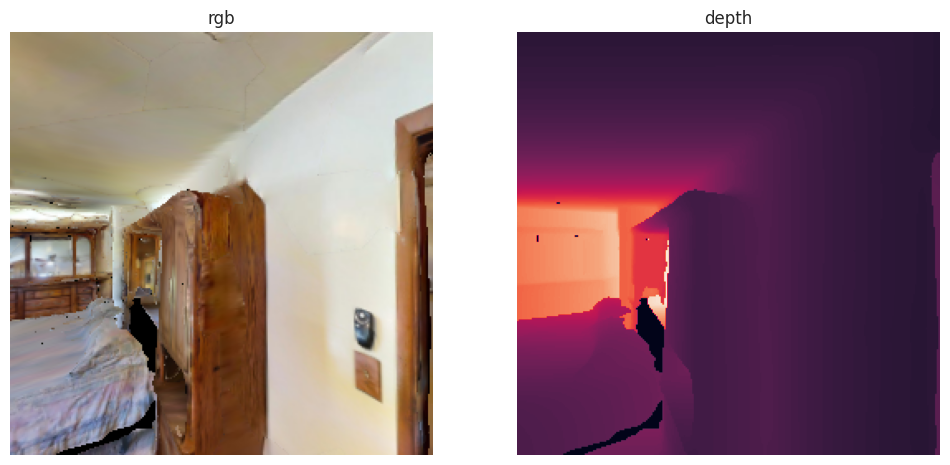

Use TGFH to control the agent now:  h


Choose to turn_right


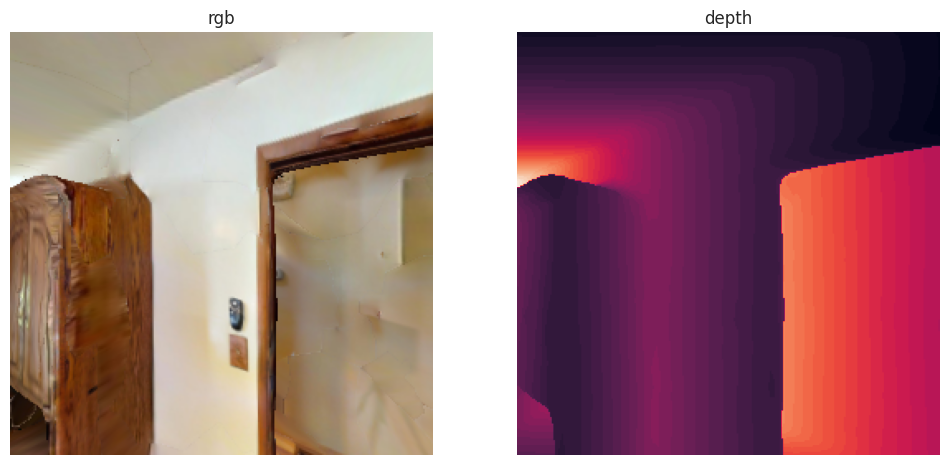

Use TGFH to control the agent now:  h


Choose to turn_right


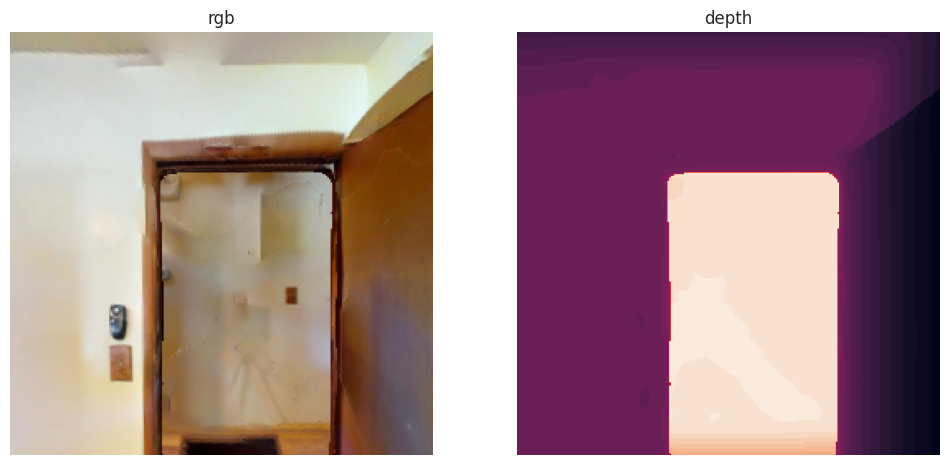

Use TGFH to control the agent now:  t


Choose to move_forward


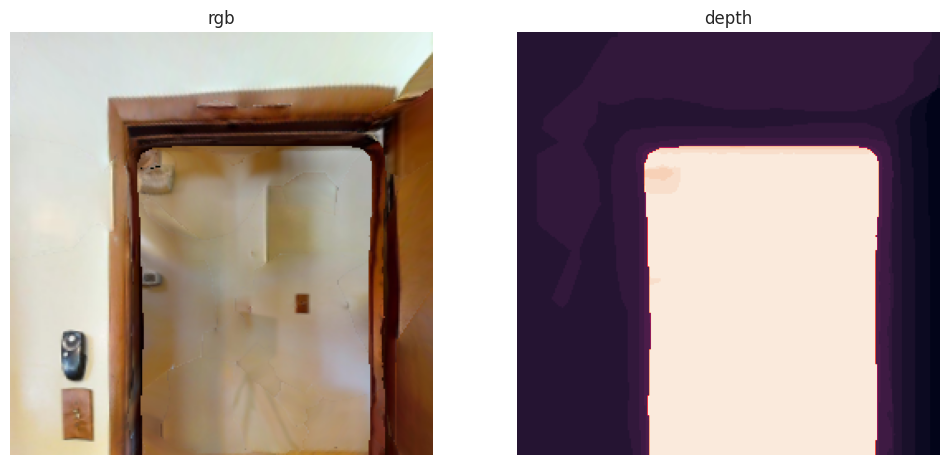

Use TGFH to control the agent now:  t


Choose to move_forward


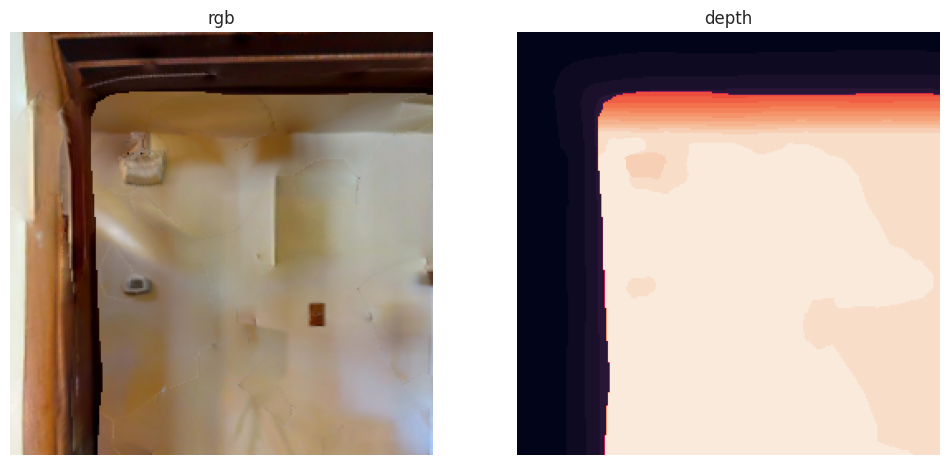

Use TGFH to control the agent now:  t


Choose to move_forward


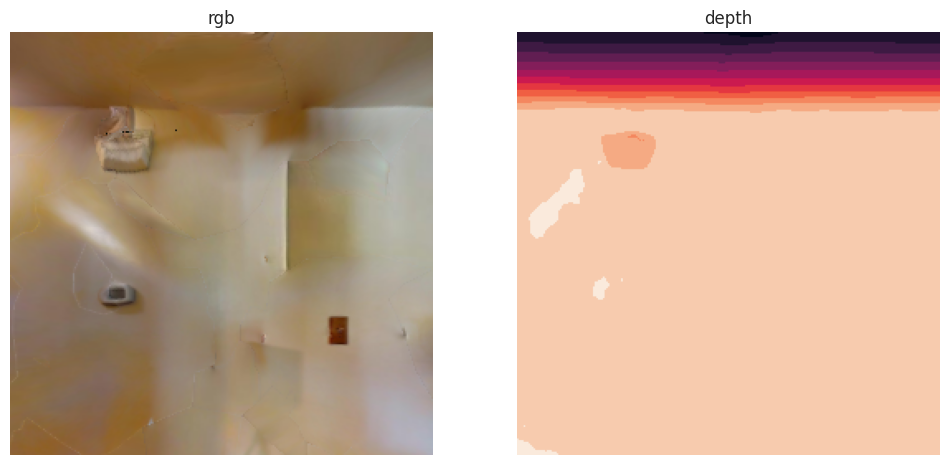

Use TGFH to control the agent now:  t


Choose to move_forward


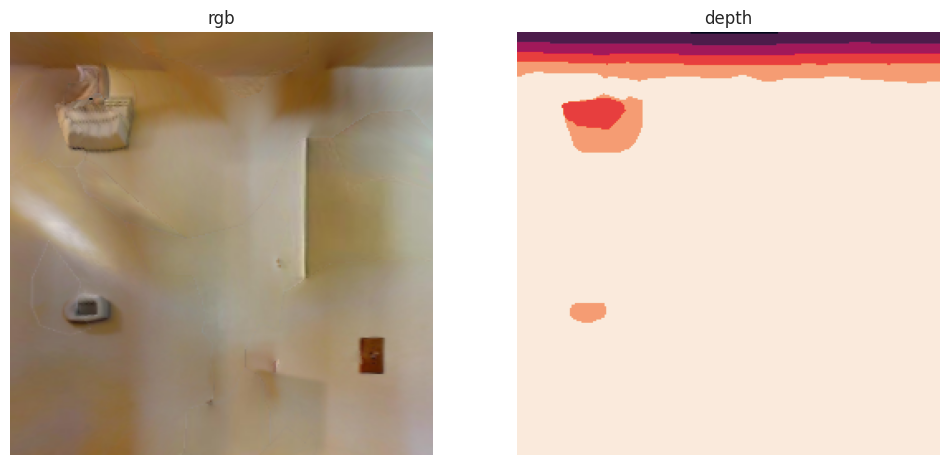

KeyboardInterrupt: Interrupted by user

In [14]:
key_bindings = {
    'T': 'move_forward',
    'G': 'move_backward',
    'F': 'turn_left',
    'H': 'turn_right',
}
while True:
    key_pressed = input('Use TGFH to control the agent now: ')
    key_pressed = key_pressed.upper()
    if key_pressed == 'O':
        print("Bye...")
        break
    elif key_pressed in key_bindings.keys():
        action = key_bindings[key_pressed]
        print(f"Choose to {action}")
        # TODO: Please enter your code here to replace ...
        # HINT: You can refer to the doc of Env at https://aihabitat.org/docs/habitat-lab/habitat.core.env.Env.html
        observations = sim.step(action)
        rgb_obs = observations["color_sensor"]
        depth_obs = observations["depth_sensor"]


        display_obs(rgb_obs, depth_obs)
    else:
        print(f"Invalid input {key_pressed}. Please only use TGFH!")

# Using a trained agent
In this section, we will close the loop and use a trained agent to navigate in the scene.

We are going to use an agent trained for [PointGoal Navigation](https://arxiv.org/abs/1807.06757). Basically, the agent is asked to *go to ($\Delta x$, $\Delta y$)* relative to its start position without a map. 

The agent is usually equipped with a RGB camera, a depth camera, and an idealized (❓) GPS+compass sensor. The GPS+compass sensor provides the distance and direction towards the target.

The reward used for training the agent contains 3 components:
1. slack reward
    $$
    r_t^\text{slack}=-0.01
    $$
2. progressed distance to goal reward
    $$
    r_t^\text{progressed distance}=r_{t-1}-r_{t}
    $$
    where $r_{t}$ is the geodesic distance to the goal (i.e., shortest path length to the goal) at time $t$.
3. success reward
    $$
    r_t^\text{success}=
    \begin{cases}
    2.5,& \text{if reach goal}\\
    0,  & \text{otherwise}
    \end{cases}
    $$

Instead of Habitat-Sim, we will use Habitat-Lab which provides an interface of vectorized environments and end-to-end reinforcement learning algorithms.

## Imports
As usual, we import some packages used afterwards.

In [15]:
import os
import random
from typing import Dict, List

import imageio
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
from omegaconf.dictconfig import DictConfig
import torch
import torch.nn as nn
import tqdm

from habitat import VectorEnv
from habitat.utils.render_wrapper import overlay_frame
from habitat.utils.visualizations.utils import observations_to_image
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.common.construct_vector_env import construct_envs
from habitat_baselines.config.default import get_config
from habitat_baselines.utils.common import (
    batch_obs,
    inference_mode,
)
from habitat_baselines.rl.ppo import PPO

os.environ['MAGNUM_LOG'] = 'quiet'
os.environ['HABITAT_SIM_LOG'] = 'quiet'

Neither `ifconfig` (`ifconfig -a`) nor `ip` (`ip address show`) commands are available, listing network interfaces is likely to fail


## Setup
Rather than specifying the configurations on-the-fly in Habitat-Sim, we can load the configurations from a `yaml` file in Habitat-Lab. Here we use the configuration file `ppo_pointnav.yaml`

In [16]:
# A function to build the evaluation config for the trained agent
def build_pretrained_config(data_path: str):
    config = get_config("pointnav/ppo_pointnav.yaml")  # Extract config from yaml
    # Change for evaluation
    OmegaConf.set_readonly(config, False)
    config.habitat_baselines.eval_ckpt_path_dir="./data/checkpoints/gibson.pth"  # Choose checkpoint
    config.habitat_baselines.num_updates = -1
    config.habitat_baselines.num_environments = 1
    config.habitat_baselines.verbose = False
    config.habitat.dataset.data_path = data_path
    OmegaConf.set_readonly(config, True)

    return config

sample_config = build_pretrained_config("data/datasets/pointnav/gibson/v1/val/val_cantwell.json.gz")

## Build environment
Let's build a vectorized envrionment from the configuration.

In [17]:
# A function to build a vectorized environment
def build_env(config: DictConfig, multiprocess=True):
    if not multiprocess:
        import os
        os.environ['HABITAT_ENV_DEBUG'] = '1'
    return construct_envs(
        config=config,
        workers_ignore_signals=False,
        enforce_scenes_greater_eq_environments=True,
    )

sample_env = build_env(config=sample_config)

2025-04-01 20:43:12,703 Initializing dataset PointNav-v1
Neither `ifconfig` (`ifconfig -a`) nor `ip` (`ip address show`) commands are available, listing network interfaces is likely to fail
2025-04-01 20:43:23,192 Initializing dataset PointNav-v1
2025-04-01 20:43:23,195 initializing sim Sim-v0
2025-04-01 20:43:26,295 Initializing task Nav-v0


## Build actor-critic and agent
Let's load the actor-critic and agent from the checkpoint specified.

__TODO: CODING EXERCISE BELOW (5pts)__

In [18]:
# A function to load the pretrained agent
def build_agent(config: DictConfig, env: VectorEnv, device: torch.device):
    ppo_cfg = config.habitat_baselines.rl.ppo  # Extract config for PPO

    policy = baseline_registry.get_policy(
        config.habitat_baselines.rl.policy.name
    )
    # TODO: Please enter your code here to replace ...
    # HINT: You can refer to the doc of VectorEnv at https://aihabitat.org/docs/habitat-lab/habitat.core.vector_env.VectorEnv.html
    observation_space = env.observation_spaces[0]
    policy_action_space = env.action_spaces[0]
    orig_policy_action_space = env.action_spaces[0]


    actor_critic = policy.from_config(  # Build the actor-critic
        config,
        observation_space,
        policy_action_space,
        orig_action_space=orig_policy_action_space,
    )
    actor_critic.to(device)

    agent = PPO.from_config(  # Build the PPO agent
        actor_critic=actor_critic,
        config=ppo_cfg,
    )

    ckpt_dict = torch.load(config.habitat_baselines.eval_ckpt_path_dir, map_location="cpu")  # Load the checkpoint
    agent.load_state_dict(ckpt_dict["state_dict"])

    actor_critic.eval()
    agent.eval()

    return actor_critic, agent

sample_device = torch.device("cpu")
sample_actor_critic, sample_agent = build_agent(config=sample_config, env=sample_env, device=sample_device)


## Build variables
Since the agent loaded is a recurrent policy, we need to build some auxiliary variables that will be taken as input by the policy.

In [19]:
# A function to build auxiliary variables for the policy
def build_variables(config: DictConfig, actor_critic: nn.Module, device: torch.device):
    test_recurrent_hidden_states = torch.zeros(  # Hidden recurrent state
        config.habitat_baselines.num_environments,
        actor_critic.num_recurrent_layers, 
        config.habitat_baselines.rl.ppo.hidden_size, 
        device=device
    )
    prev_actions = torch.zeros(  # Previous action
        config.habitat_baselines.num_environments,
        1,
        device=device,
        dtype=torch.long,
    )
    not_done_masks = torch.zeros(
        config.habitat_baselines.num_environments,
        1,
        device=device,
        dtype=torch.bool,
    )

    return test_recurrent_hidden_states, prev_actions, not_done_masks

sample_test_recurrent_hidden_states, sample_prev_actions, sample_not_done_masks = build_variables(
    config=sample_config, 
    actor_critic=sample_actor_critic, 
    device=sample_device
)


## Agent navigation
We will used the trained policy for PointGoal navigation now. The agent takes RGBD image and GPS+compass measurement as input. It was trained by [Proximal Policy Optimization](https://arxiv.org/abs/1707.06347), a reinforcement learning algorithm.

We can evaluate the agent with the following metrics:
1. success: `bool`
2. success weighted by path length (SPL): `float`
    $$
    SPL=S\frac{L}{\max(P, L)}
    $$
    where $S$ is 1 or 0 indicating success or not, $P$ is the length of the agent's path, and $L$ is the length of the shortest path from the start point to the goal point (not necessariy the straight line between the start point and the goal point)
3. undiscounted return: `float`

__TODO: CODING EXERCISE BELOW (15pts)__
* __FIRST: 5pts__
* __SECOND: 10pts__

In [20]:
# A function to map observations to actions using the pretained agent
def step_agent(actor_critic: nn.Module, batch: Dict[str, torch.Tensor], test_recurrent_hidden_states: torch.Tensor, prev_actions: torch.Tensor, not_done_masks: torch.Tensor):
    with inference_mode():
        (
            _,
            actions,
            _,
            test_recurrent_hidden_states,
        ) = actor_critic.act(
            batch,
            test_recurrent_hidden_states,
            prev_actions,
            not_done_masks,
            deterministic=False,
        )

        prev_actions.copy_(actions)  # type: ignore

    return actions, test_recurrent_hidden_states



# A function to excecute simulation within the environment
def step_env(env: VectorEnv, actions: torch.Tensor):
    # TODO: Please enter your code here to replace ...
    # HINT: You can refer to the doc of VectorEnv at https://aihabitat.org/docs/habitat-lab/habitat.core.vector_env.VectorEnv.html
    step_data = [int(a) for a in actions.cpu().numpy()]
    outputs = env.step(step_data)




    observations, rewards_l, dones, infos = [
        list(x) for x in zip(*outputs)
    ]
    
    return observations, rewards_l, dones, infos


# A utility function to post-process the results
def post_process(observations: List[Dict], dones: List[bool], device: torch.device):
    batch = batch_obs(  # type: ignore
        observations,
        device=device,
    )

    not_done_masks = torch.tensor(
        [[not done] for done in dones],
        dtype=torch.bool,
        device=device,
    )

    return batch, not_done_masks


# A utility function to collect rewards in an episode
def collect_rewards(rewards_l: List[float], ep_rewards: List[float]):
    rewards = torch.tensor(
        rewards_l, dtype=torch.float, device="cpu"
    ).unsqueeze(1)
    ep_rewards.append(rewards[0].item())


# A utility function to collect frames in an episode
def collect_frames(batch: Dict[str, torch.Tensor], infos: List[Dict], not_done_masks: torch.Tensor, ep_frames: List[np.ndarray]):
    frame = observations_to_image(
        {k: v[0] for k, v in batch.items()}, infos[0]
    )
    if not not_done_masks[0].item():
        # The last frame corresponds to the first frame of the next episode
        # but the info is correct. So we use a black frame
        frame = observations_to_image(
            {k: v[0] * 0.0 for k, v in batch.items()}, infos[0]
        )
    frame = overlay_frame(frame, infos[0])
    ep_frames.append(frame)


# A utility function to generate video from collected frames
def generate_video(ep_frames: List[np.ndarray], video_name: str, output_dir: str = "output_video", fps: int = 10):
    output_dir = output_dir.lower().replace(" ", "_")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    video_name = video_name.lower().replace(" ", "_")
    
    writer = imageio.get_writer(
        os.path.join(output_dir, video_name),
        fps=fps
    )

    frames_iter = tqdm.tqdm(ep_frames)
    for fm in frames_iter:
        writer.append_data(fm)
    writer.close()


In [21]:
def loop_env(config: DictConfig, scene_name: str, agent_name: str, add_drift: bool = False, drift_func = None):
    # Set the randomness requried later
    random.seed(config.habitat.seed)
    np.random.seed(config.habitat.seed)
    torch.manual_seed(config.habitat.seed)

    # Choose device for cuda or cpu
    device = torch.device("cuda", config.habitat_baselines.torch_gpu_id) if torch.cuda.is_available() else torch.device("cpu")

    # Build the vectorized environment
    env = build_env(config=config)

    # Build the actor-critic and agent from a checkpoint
    actor_critic, agent = build_agent(config=config, env=env, device=device)

    # Build auxiliary variables
    test_recurrent_hidden_states, prev_actions, not_done_masks = build_variables(
        config=config, 
        actor_critic=actor_critic, 
        device=device
    )

    observations = env.reset()  # Reset the environment, e.g., move the agent back to its start location
    batch = batch_obs(observations, device=device)

    rng = np.random.default_rng()
    sign, scale = None, None

    n_step = 0
    episodes_stats = {}
    ep_rewards, ep_frames = [], []
    while len(episodes_stats) < env.number_of_episodes[0]:
        ep_name = env.current_episodes()[0].episode_id
        actions, test_recurrent_hidden_states = step_agent(  # Map observations to actions
            actor_critic=actor_critic,
            batch=batch,
            test_recurrent_hidden_states=test_recurrent_hidden_states,
            prev_actions=prev_actions,
            not_done_masks=not_done_masks,
        )

        observations, rewards_l, dones, infos = step_env(  # One step forward of simulation in the environment
            env=env,
            actions=actions,
        )
        if add_drift:
            if sign is None:
                sign = rng.choice((-1, 1))  # Direction for drift
                scale = 0.05  # Scale the drift w.r.t. steps
            drift_func(
                observations=observations,
                n_step=n_step,
                sign=sign,
                scale=scale
            )

        batch, not_done_masks = post_process(  # Post-process the results
            observations=observations,
            dones=dones,
            device=device,
        )

        collect_rewards(  # Collect rewards
            rewards_l=rewards_l,
            ep_rewards=ep_rewards,
        )

        collect_frames(  # Collect frames
            batch=batch,
            infos=infos,
            not_done_masks=not_done_masks,
            ep_frames=ep_frames
        )

        n_step += 1
        if not not_done_masks[0].item():  # Episode ended
            last_infos = infos.copy()

            episodes_stats[ep_name] = {
                'success': last_infos[0]['success'],
                'spl': last_infos[0]['spl'],
                'return': sum(ep_rewards),
            }

            # Generate video
            generate_video(
                ep_frames=ep_frames,
                video_name=f"ep={ep_name}_success={last_infos[0]['success']}_spl={last_infos[0]['spl']}.mp4",
                output_dir=f"output_video/{scene_name}/{agent_name}"
            )

            # Clean
            n_step = 0
            ep_rewards, ep_frames = [], []

            # Build auxiliary variables
            test_recurrent_hidden_states, prev_actions, not_done_masks = build_variables(
                config=config, 
                actor_critic=actor_critic, 
                device=device
            )

    success_l, spl_l, return_l = [], [], []
    for ep_stat in episodes_stats.values():
        success_l.append(ep_stat['success'])
        spl_l.append(ep_stat['spl'])
        return_l.append(ep_stat['return'])

    avg_success = sum(success_l) / len(success_l)
    avg_spl = sum(spl_l) / len(spl_l)
    avg_return = sum(return_l) / len(return_l)

    print(f"In {scene_name}, {agent_name}")
    print(f"\t Average success rate: {avg_success}")
    print(f"\t Average SPL: {avg_spl}")
    print(f"\t Average return: {avg_return}")

    return {
        'success': avg_success,
        'spl': avg_spl,
        'return': avg_return
    }


In [35]:
# Build configuration
config = build_pretrained_config("data/datasets/pointnav/gibson/v1/val/val_cantwell.json.gz")

# Start loop env for evaluation
stats_pretrained_cantwell = loop_env(config=config, scene_name='Cantwell', agent_name='Pretrained Agent')

2025-04-01 20:57:25,154 Initializing dataset PointNav-v1
2025-04-01 20:57:25,167 Using the debug Vector environment interface. Expect slower performance.
2025-04-01 20:57:25,168 Initializing dataset PointNav-v1
2025-04-01 20:57:25,171 initializing sim Sim-v0
2025-04-01 20:57:28,177 Initializing task Nav-v0
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 483.58it/s]


In Cantwell, Pretrained Agent
	 Average success rate: 0.8450704225352113
	 Average SPL: 0.6988172601318694
	 Average return: 8.84642204487533


## Drift on GPS and compass measurements
Did you feel something wrong with the **idealized** GPS+compass sensor (i.e., producing noiseless measurements for the distance and direction towards the target)? The GPS and compass measurements are usually drifted in indoor scenes. 

Let's add some simulated drift to GPS and compass measurements and see what will happen.

In [22]:
# A functionn to simulate drift on the GPS and compass measurements
# It adds drift which is a linear function to number of steps
def simulate_drift(observations: List[Dict], n_step: int, sign: int, scale: float):
    rho_drift = sign * n_step * scale
    phi_drift = sign * n_step * np.pi * scale
    observations[0]['pointgoal_with_gps_compass'][0] += rho_drift
    observations[0]['pointgoal_with_gps_compass'][1] += phi_drift
    observations[0]['pointgoal_with_gps_compass'][1] %= 2 * np.pi  # mod
    observations[0]['pointgoal_with_gps_compass'][1] -= np.pi  # map to -pi~pi

In [36]:
# Build the config using a new scene
config = build_pretrained_config("data/datasets/pointnav/gibson/v1/val/val_cantwell.json.gz")

# Start loop env for evaluation
stats_pretrained_drift_cantwell = loop_env(config=config, scene_name='Cantwell', agent_name='Pretrained Agent With Drift', add_drift=True, drift_func=simulate_drift)

2025-04-01 20:59:51,439 Initializing dataset PointNav-v1
2025-04-01 20:59:51,452 Using the debug Vector environment interface. Expect slower performance.
2025-04-01 20:59:51,453 Initializing dataset PointNav-v1
2025-04-01 20:59:51,455 initializing sim Sim-v0
2025-04-01 20:59:54,468 Initializing task Nav-v0
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 571.23it/s]


In Cantwell, Pretrained Agent With Drift
	 Average success rate: 0.0
	 Average SPL: 0.0
	 Average return: -2.7538919240976125


### **Question** (20 pts)

1. What happens if we add drift to the GPS and compass measurements? *(observe)*
2. Why do you think the agent does not rely more on vision and fails in this case? *(hypothesize)*

__Answer:__

1. When drift is added to the GPS and compass, the agent becomes disoriented and unable to reach the goal. This is reflected in the success rate and SPL dropping to 0. The negative return also indicates that the agent takes inefficient or incorrect actions due to incorrect localization.

2. The agent does not rely more on vision because, during training, GPS and compass signals were consistently reliable and easier for the policy to exploit. As a result, the agent learned to prioritize those inputs for decision-making. Vision requires more complex processing and may have been underutilized in the training signal or gradient flow, leading to poor generalization when localization signals degrade.

# Control Baselines
We observed how an agent trained for PointGoal navigation performs. Does it perform well or not? To answer this quesion, we need to put its performance into a context and introduce the following control baselines:
1. Random walk -- provides the lower bound on the performance
2. Shortest path -- provides the upper bound on the performance

We will evaluate the baselines in two scenes: one is [Cantwell](http://gibsonenv.stanford.edu/models/?id=Cantwell) as used before while the other one is [Edgemere](http://gibsonenv.stanford.edu/models/?id=Edgemere). The topdown map of the two scenes are shown below.

Cantwell             |  Edgemere
:-------------------------:|:-------------------------:
<img src="images/top_down_map_Cantwell.png" alt="Topdown map of Cantwell" width="50%" height="50%"/>  |  <img src="images/top_down_map_Edgemere.png" alt="Topdown map of Edgemere" width="50%" height="50%"/>

## Vision-based agent
Here we evalute the performance of our pretrained agent mentioned above in Edgemere.

In [37]:
# Build configuration
config = build_pretrained_config("data/datasets/pointnav/gibson/v1/val/val_edgemere.json.gz")

# Start loop env for evaluation
stats_pretrained_edgemere = loop_env(config=config, scene_name='Edgemere', agent_name='Pretrained Agent')

2025-04-01 21:05:22,816 Initializing dataset PointNav-v1
2025-04-01 21:05:22,829 Using the debug Vector environment interface. Expect slower performance.
2025-04-01 21:05:22,830 Initializing dataset PointNav-v1
2025-04-01 21:05:22,833 initializing sim Sim-v0
2025-04-01 21:05:23,641 Initializing task Nav-v0
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 441.86it/s]

In Edgemere, Pretrained Agent
	 Average success rate: 0.971830985915493
	 Average SPL: 0.8999728726802186
	 Average return: 5.262807225431382


## Random walk
The agent randomly walks in the scene. Here, it randomly chooses the action among `move_forward`(1), `turn_left`(2), and `turn_right`(3). 

If set `include_stop=True`, the agent also includes `stop`(0) in to choices, which will cause the episode end very soon. Just have a try!

In [23]:
# A function to randomly choose an action
def step_random_walk_agent(include_stop=False):
    lower = 0 if include_stop else 1
    return torch.randint(lower, 4, size=(1, 1), dtype=torch.long)


In [24]:
def loop_random_walk_env(config: DictConfig, scene_name: str, agent_name: str):
    # Set the randomness requried later
    random.seed(config.habitat.seed)
    np.random.seed(config.habitat.seed)
    torch.manual_seed(config.habitat.seed)

    # Choose device for cuda or cpu
    device = torch.device("cuda", config.habitat_baselines.torch_gpu_id) if torch.cuda.is_available() else torch.device("cpu")

    # Build the vectorized environment
    env = build_env(config=config)

    observations = env.reset()  # Reset the environment
    batch = batch_obs(observations, device=device)

    n_step = 0
    episodes_stats = {}
    ep_rewards, ep_frames = [], []
    last_info = None
    while len(episodes_stats) < env.number_of_episodes[0]:
        ep_name = env.current_episodes()[0].episode_id
        actions = step_random_walk_agent()  # Randomly choose an action

        observations, rewards_l, dones, infos = step_env(  # One step forward of simulation in the environment
            env=env,
            actions=actions,
        )

        batch, not_done_masks = post_process(  # Post-process the results
            observations=observations,
            dones=dones,
            device=device,
        )

        collect_rewards(  # Collect rewards
            rewards_l=rewards_l,
            ep_rewards=ep_rewards,
        )

        collect_frames(  # Collect frames
            batch=batch,
            infos=infos,
            not_done_masks=not_done_masks,
            ep_frames=ep_frames
        )

        n_step += 1
        if not not_done_masks[0].item():  # Episode ended
            last_infos = infos.copy()

            episodes_stats[ep_name] = {
                'success': last_infos[0]['success'],
                'spl': last_infos[0]['spl'],
                'return': sum(ep_rewards),
            }

            # Generate video
            generate_video(
                ep_frames=ep_frames,
                video_name=f"ep={ep_name}_success={last_infos[0]['success']}_spl={last_infos[0]['spl']}.mp4",
                output_dir=f"output_video/{scene_name}/{agent_name}"
            )

            # Clean
            n_step = 0
            ep_rewards, ep_frames = [], []

    success_l, spl_l, return_l = [], [], []
    for ep_stat in episodes_stats.values():
        success_l.append(ep_stat['success'])
        spl_l.append(ep_stat['spl'])
        return_l.append(ep_stat['return'])

    avg_success = sum(success_l) / len(success_l)
    avg_spl = sum(spl_l) / len(spl_l)
    avg_return = sum(return_l) / len(return_l)

    print(f"In {scene_name}, {agent_name}")
    print(f"\t Average success rate: {avg_success}")
    print(f"\t Average SPL: {avg_spl}")
    print(f"\t Average return: {avg_return}")

    return {
        'success': avg_success,
        'spl': avg_spl,
        'return': avg_return
    }

### Evaluation in Cantwell

In [38]:
# Build configuration
config = build_pretrained_config("data/datasets/pointnav/gibson/v1/val/val_cantwell.json.gz")

# Start loop random walk env for evaluation
stats_random_walk_cantwell = loop_random_walk_env(config=config, scene_name='Cantwell', agent_name='Random Walk Agent')

2025-04-01 21:05:55,391 Initializing dataset PointNav-v1
2025-04-01 21:05:55,403 Using the debug Vector environment interface. Expect slower performance.
2025-04-01 21:05:55,404 Initializing dataset PointNav-v1
2025-04-01 21:05:55,407 initializing sim Sim-v0
2025-04-01 21:05:58,437 Initializing task Nav-v0
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 733.51it/s]


In Cantwell, Random Walk Agent
	 Average success rate: 0.0
	 Average SPL: 0.0
	 Average return: -5.225807000498912


### Evaluation in Edgemere

In [39]:
# Build configuration
config = build_pretrained_config("data/datasets/pointnav/gibson/v1/val/val_edgemere.json.gz")

# Start loop random walk env for evaluation
stats_random_walk_edgemere = loop_random_walk_env(config=config, scene_name='Edgemere', agent_name='Random Walk Agent')

2025-04-01 21:09:23,382 Initializing dataset PointNav-v1
2025-04-01 21:09:23,394 Using the debug Vector environment interface. Expect slower performance.
2025-04-01 21:09:23,396 Initializing dataset PointNav-v1
2025-04-01 21:09:23,400 initializing sim Sim-v0
2025-04-01 21:09:24,184 Initializing task Nav-v0
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 772.83it/s]

In Edgemere, Random Walk Agent
	 Average success rate: 0.0
	 Average SPL: 0.0
	 Average return: -5.1230753430035305


## Shortest path
This agent knows the ground truth of map and follows the shortest path towards the target position.

We can compare its performance against our agent trained with RL. Let's see which one uses fewer steps to arrive at the target position.

In [26]:
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower


# A function to build the agent that knows the shortest path towards the target
def build_shortest_path_agent(env: VectorEnv):
    # unwrap env
    internal_env = env.call_at(0, function_name='env').env.env._env._env
    sim = internal_env.sim

    follower = ShortestPathFollower(  # Build the shortest path follower
        sim=sim,
        goal_radius=0.1,
        return_one_hot=False,
    )

    return follower, internal_env


# A function to choose the best action from the shortest path follower
def step_shortest_path_agent(follower: ShortestPathFollower, goal_pos: List[float]):
    best_action = follower.get_next_action(goal_pos=goal_pos)

    return torch.tensor([[best_action]], dtype=torch.long)

In [27]:
def loop_shortest_path_env(config: DictConfig, scene_name: str, agent_name: str):
    # Set the randomness requried later
    random.seed(config.habitat.seed)
    np.random.seed(config.habitat.seed)
    torch.manual_seed(config.habitat.seed)

    # Choose device for cuda or cpu
    device = torch.device("cuda", config.habitat_baselines.torch_gpu_id) if torch.cuda.is_available() else torch.device("cpu")

    # Build the vectorized environment without multi-processing
    env = build_env(config=config, multiprocess=False)
    agent, internal_env = build_shortest_path_agent(env=env)

    observations = env.reset()  # Reset the environment
    batch = batch_obs(observations, device=device)

    n_step = 0
    episodes_stats = {}
    ep_rewards, ep_frames = [], []
    while len(episodes_stats) < env.number_of_episodes[0]:
        ep_name = env.current_episodes()[0].episode_id
        actions = step_shortest_path_agent(agent, goal_pos=internal_env.current_episode.goals[0].position)  # Choose the optimal action towards the target

        observations, rewards_l, dones, infos = step_env(  # One step forward of simulation in the environment
            env=env,
            actions=actions,
        )

        batch, not_done_masks = post_process(  # Post-process the results
            observations=observations,
            dones=dones,
            device=device,
        )

        collect_rewards(  # Collect rewards
            rewards_l=rewards_l,
            ep_rewards=ep_rewards,
        )

        collect_frames(  # Collect frames
            batch=batch,
            infos=infos,
            not_done_masks=not_done_masks,
            ep_frames=ep_frames
        )

        n_step += 1
        if not not_done_masks[0].item():  # Episode ended
            last_infos = infos.copy()

            episodes_stats[ep_name] = {
                'success': last_infos[0]['success'],
                'spl': last_infos[0]['spl'],
                'return': sum(ep_rewards),
            }

            # Generate video
            generate_video(
                ep_frames=ep_frames,
                video_name=f"ep={ep_name}_success={last_infos[0]['success']}_spl={last_infos[0]['spl']}.mp4",
                output_dir=f"output_video/{scene_name}/{agent_name}"
            )

            # Clean
            n_step = 0
            ep_rewards, ep_frames = [], []


    success_l, spl_l, return_l = [], [], []
    for ep_stat in episodes_stats.values():
        success_l.append(ep_stat['success'])
        spl_l.append(ep_stat['spl'])
        return_l.append(ep_stat['return'])

    avg_success = sum(success_l) / len(success_l)
    avg_spl = sum(spl_l) / len(spl_l)
    avg_return = sum(return_l) / len(return_l)

    print(f"In {scene_name}, {agent_name}")
    print(f"\t Average success rate: {avg_success}")
    print(f"\t Average SPL: {avg_spl}")
    print(f"\t Average return: {avg_return}")

    return {
        'success': avg_success,
        'spl': avg_spl,
        'return': avg_return
    }

### Evaluation in Cantwell

In [28]:
# Build configuration
config = build_pretrained_config("data/datasets/pointnav/gibson/v1/val/val_cantwell.json.gz")

# Start loop shortest path env for evaluation
stats_shortest_path_cantwell = loop_shortest_path_env(config=config, scene_name='Cantwell', agent_name='Shortest Path Agent')

2025-04-01 20:47:57,473 Initializing dataset PointNav-v1
2025-04-01 20:47:57,486 Using the debug Vector environment interface. Expect slower performance.
2025-04-01 20:47:57,488 Initializing dataset PointNav-v1
2025-04-01 20:47:57,491 initializing sim Sim-v0
2025-04-01 20:48:00,555 Initializing task Nav-v0
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 477.99it/s]


In Cantwell, Shortest Path Agent
	 Average success rate: 0.971830985915493
	 Average SPL: 0.9647867878100914
	 Average return: 11.027438541716883


### Evaluation in Edgemere

In [29]:
# Build configuration
config = build_pretrained_config("data/datasets/pointnav/gibson/v1/val/val_edgemere.json.gz")

# Start loop shortest path env for evaluation
stats_shortest_path_edgemere = loop_shortest_path_env(config=config, scene_name='Edgemere', agent_name='Shortest Path Agent')

2025-04-01 20:48:55,993 Initializing dataset PointNav-v1
2025-04-01 20:48:56,005 Using the debug Vector environment interface. Expect slower performance.
2025-04-01 20:48:56,007 Initializing dataset PointNav-v1
2025-04-01 20:48:56,009 initializing sim Sim-v0
2025-04-01 20:48:56,834 Initializing task Nav-v0
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 521.22it/s]

In Edgemere, Shortest Path Agent
	 Average success rate: 1.0
	 Average SPL: 0.9780787785640307
	 Average return: 5.3609017841747475


## Blind (GPS+Compass only) Agent
Our previous trained agent takes both RGBD images and GPS+compass measurements as input.
As we observed before (introducing the drift to the scensors), the agent relies a lot on the GPS+compass measurements.
In this section, we will estimate *whether vision is useful for navigation*.
For that we load an agent that only uses GPS+compass measurements for navigation.

In [30]:
# A function to build the evaludation config for the GPS+compass only agent
def build_state_only_config(data_path: str):
    config = get_config("pointnav/ppo_pointnav.yaml")
    # Minor change
    OmegaConf.set_readonly(config, False)
    config.habitat_baselines.eval_ckpt_path_dir = "data/checkpoints/gibson_blind.pth"  # Choose blind checkpoint
    config.habitat_baselines.num_updates = -1
    config.habitat_baselines.num_environments = 1
    config.habitat_baselines.verbose = False
    config.habitat_baselines.force_blind_policy = True
    config.habitat.dataset.data_path = data_path
    OmegaConf.set_readonly(config, True)

    return config


### Evaluation in Cantwell

In [31]:
# Build config for state only agent
config = build_state_only_config("data/datasets/pointnav/gibson/v1/val/val_cantwell.json.gz")

# Start loop env for evaluation
stats_blind_cantwell = loop_env(config=config, scene_name='Cantwell', agent_name='Pretrained Agent without Vision')

2025-04-01 20:51:14,770 Initializing dataset PointNav-v1
2025-04-01 20:51:14,783 Using the debug Vector environment interface. Expect slower performance.
2025-04-01 20:51:14,784 Initializing dataset PointNav-v1
2025-04-01 20:51:14,787 initializing sim Sim-v0
2025-04-01 20:51:17,843 Initializing task Nav-v0
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 566.71it/s]


In Cantwell, Pretrained Agent without Vision
	 Average success rate: 0.352112676056338
	 Average SPL: 0.2230271446971083
	 Average return: 1.9633206207487655


### Evaluation in Edgemere

In [32]:
# Build config for state only agent
config = build_state_only_config("data/datasets/pointnav/gibson/v1/val/val_edgemere.json.gz")

# Start loop env for evaluation
stats_blind_edgemere = loop_env(config=config, scene_name='Edgemere', agent_name='Pretrained Agent without Vision')

2025-04-01 20:53:34,626 Initializing dataset PointNav-v1
2025-04-01 20:53:34,638 Using the debug Vector environment interface. Expect slower performance.
2025-04-01 20:53:34,639 Initializing dataset PointNav-v1
2025-04-01 20:53:34,642 initializing sim Sim-v0
2025-04-01 20:53:35,470 Initializing task Nav-v0
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 448.20it/s]


In Edgemere, Pretrained Agent without Vision
	 Average success rate: 0.971830985915493
	 Average SPL: 0.621402119491721
	 Average return: 4.896355358012032


In [40]:
import pandas as pd
df = pd.DataFrame(columns=['scene', 'agent', 'success', 'spl', 'return'])
df = pd.concat([
    df, 
    pd.DataFrame({
        'scene': 'Cantwell',
        'agent': 'Shortest Path',
        **stats_shortest_path_cantwell,
    }, index=[0]),
    pd.DataFrame({
        'scene': 'Edgemere',
        'agent': 'Shortest Path',
        **stats_shortest_path_edgemere,
    }, index=[0]),
    pd.DataFrame({
        'scene': 'Cantwell',
        'agent': 'Blind Agent',
        **stats_blind_cantwell,
    }, index=[0]),
    pd.DataFrame({
        'scene': 'Edgemere',
        'agent': 'Blind Agent',
        **stats_blind_edgemere,
    }, index=[0]),
    pd.DataFrame({
        'scene': 'Cantwell',
        'agent': 'Vision Agent',
        **stats_pretrained_cantwell,
    }, index=[0]),
    pd.DataFrame({
        'scene': 'Edgemere',
        'agent': 'Vision Agent',
        **stats_pretrained_edgemere,
    }, index=[0]),
    pd.DataFrame({
        'scene': 'Cantwell',
        'agent': 'Random Walk',
        **stats_random_walk_cantwell,
    }, index=[0]),
    pd.DataFrame({
        'scene': 'Edgemere',
        'agent': 'Random Walk',
        **stats_random_walk_edgemere,
    }, index=[0]),
])

Text(0.5, 1.0, 'Success')

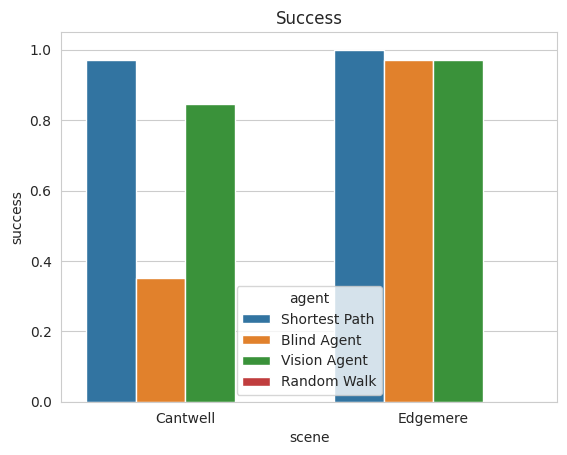

In [41]:
sns.barplot(x='scene', y='success', hue='agent', data=df)
plt.title('Success')

Text(0.5, 1.0, 'SPL')

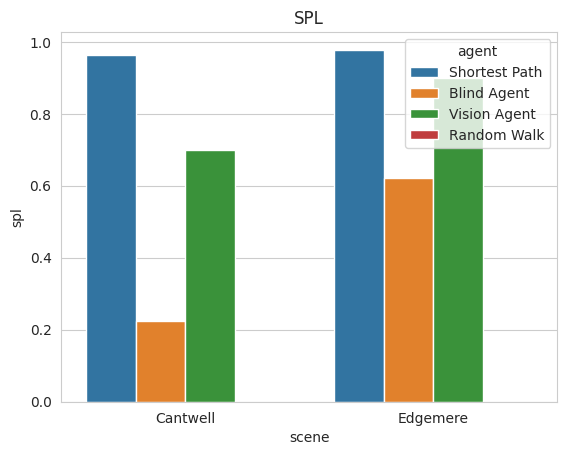

In [42]:
sns.barplot(x='scene', y='spl', hue='agent', data=df)
plt.title('SPL')

### **Question** (30 pts)

1. Is there a difference in the performance of the blind agent and agent with addiitonal visual signal? How does it vary w.r.t. the scene? *(observe)*

Yes, there is a clear difference. In Cantwell, the Vision Agent outperforms the Blind Agent in both success and SPL. In Edgemere, their performance is similar, both achieving high success and SPL.

 
2. What do you think is the reason? *(hypothesize)*

The Blind Agent struggles more in Cantwell, possibly because it cannot use visual cues to navigate effectively. In Edgemere, the environment may be easier to navigate without vision, so the gap narrows. In complex scenes, a purely blind approach struggles because it cannot correct for odometry drift or localize itself based on visuals.

3. How would you answer the question "Is vision useful for navigation"? *(conclude)*

Yes, vision is generally very useful for navigation. It provides spatial context and helps the agent adapt to variations in the environment, making navigation more robust than relying on minimal sensors alone. It clearly improves performance in more challenging settings, as shown by the gap in Cantwell.

# Train a state-based policy
In this section, we will train the GPS+compass agent in a simple room. We will compare two reinforcement learning algorithms:
1. Policy Gradient (REINFORCE)
2. Proximal Policy Optimization (PPO)

*You will get to implement the REINFORCE algorithm* in this section, and use PPO from the Habitat-Lab library.

## Imports
We now import some packages used later.

In [43]:
import random

import numpy as np
from omegaconf import OmegaConf
import torch
import torch.nn.functional as F

from habitat_baselines.config.default import get_config
from habitat_baselines.rl.ppo.ppo_trainer import PPOTrainer

from pg.base_pg import BasePolicyGradient
from pg.base_pg_trainer import BasePolicyGradientTrainer

## REINFORCE
REINFORCE is an on-policy reinforcement learning algorithm. The update process could be desribe as follow:
1. Initialize the policy parameters $\theta$
2. Collect rollouts with policy $\pi_\theta$: $(s_0, a_0, r_0, s_1, a_1, \cdots, s_T)$
3. For $t=T, T-1, \cdots, 1$,
    1. Calculate the return $R_t$
    2. Update the policy parameters $\theta=\theta+\alpha R_t\nabla_\theta \log(\pi_\theta(a_t|s_t))$, where $\alpha$ is a learning rate.

Ready? Let's implement the loss computation of REINFORCE below. 

Note that we do not expect REINFORCE to perform well in the PointGoal Navigation task. So please just implement the action loss and value loss computation as shown above. No further tuning is required.

__TODO: CODING EXERCISE BELOW (20pts)__
* __FIRST: 10pts__
* __SECOND: 10pts__

In [44]:
class REINFORCE(BasePolicyGradient):
    def _compute_action_loss(
            self,
            advantages: torch.Tensor,  # Advantage, A_t
            returns: torch.Tensor,  # Return, R_t
            action_log_probs: torch.Tensor,  # Log action probability, log(pi(a_t|s_t))
            values: torch.Tensor  # Value prediction, V_t
    ):
        # TODO: Please enter your code here to replace ...
        action_loss = -(action_log_probs * advantages).mean()

        return action_loss

    def _compute_value_loss(
            self,
            advantages: torch.Tensor,  # Advantage, A_t
            returns: torch.Tensor,  # Return, R_t
            action_log_probs: torch.Tensor,  # Log action probability, log(pi(a_t|s_t))
            values: torch.Tensor  # Value prediction, V_t
    ):
        # TODO: Please enter your code here to replace ...
        value_loss = F.mse_loss(values, returns)

        return value_loss

class REINFORCETrainer(BasePolicyGradientTrainer):
    def _agent_type(self):
        return REINFORCE

In [45]:
# A function to build configuration for REINFORCE training
def build_REINFORCE_config():
    config = get_config("pointnav/ppo_pointnav.yaml")
    # Change for REINFORCE
    OmegaConf.set_readonly(config, False)
    config.habitat_baselines.checkpoint_folder = "data/REINFORCE_checkpoints"
    config.habitat_baselines.tensorboard_dir = "tb/REINFORCE"
    config.habitat_baselines.num_updates = -1
    config.habitat_baselines.num_environments = 2
    config.habitat_baselines.verbose = False
    config.habitat_baselines.num_checkpoints = -1
    config.habitat_baselines.checkpoint_interval = 1000000
    config.habitat_baselines.total_num_steps = 150 * 1000
    config.habitat_baselines.force_blind_policy = True
    config.habitat_baselines.rl.ppo.use_gae = False  # Use Monte-Carlo estimation for returns
    config.habitat.dataset.data_path="data/datasets/pointnav/simple_room/v0/{split}/empty_room.json.gz"
    OmegaConf.set_readonly(config, True)

    return config

config = build_REINFORCE_config()

# Set randomness
random.seed(config.habitat.seed)
np.random.seed(config.habitat.seed)
torch.manual_seed(config.habitat.seed)
if (
    config.habitat_baselines.force_torch_single_threaded
    and torch.cuda.is_available()
):
    torch.set_num_threads(1)

In [46]:
import os
os.environ["MAGNUM_LOG"] = "quiet"
os.environ["HABITAT_SIM_LOG"] = "quiet"

# Build the trainer and start training
trainer = REINFORCETrainer(config)
trainer.train()

2025-04-01 21:14:43,826 Initializing dataset PointNav-v1
2025-04-01 21:14:44,320 There are less scenes (1) than environments (2). Each environment will use all the scenes instead of using a subset.
2025-04-01 21:14:44,338 Using the debug Vector environment interface. Expect slower performance.
2025-04-01 21:14:44,339 Initializing dataset PointNav-v1
2025-04-01 21:14:44,340 Initializing dataset PointNav-v1
2025-04-01 21:14:44,666 initializing sim Sim-v0
2025-04-01 21:14:49,678 Initializing task Nav-v0
2025-04-01 21:14:49,707 initializing sim Sim-v0
2025-04-01 21:14:54,227 Initializing task Nav-v0
2025-04-01 21:14:55,480 agent number of parameters: 890661
2025-04-01 21:16:22,530 update: 25	fps: 73.675	
2025-04-01 21:16:22,532 update: 25	env-time: 42.580s	pth-time: 18.055s	frames: 6400
2025-04-01 21:16:22,533 Average window size: 25  distance_to_goal: 18.079  distance_to_goal_reward: 0.000  reward: -0.014  spl: 0.000  success: 0.000
2025-04-01 21:18:05,139 update: 50	fps: 67.555	
2025-04-

## PPO
Let us now train a PPO agent. We will use the PPO agent from Habitat-Lab.

In [47]:
# A function to build configuration for PPO training
def build_PPO_config():
    config = get_config("pointnav/ppo_pointnav.yaml")
    # Change for REINFORCE
    OmegaConf.set_readonly(config, False)
    config.habitat_baselines.checkpoint_folder = "data/PPO_checkpoints"
    config.habitat_baselines.tensorboard_dir = "tb/PPO"
    config.habitat_baselines.num_updates = -1
    config.habitat_baselines.num_environments = 2
    config.habitat_baselines.verbose = False
    config.habitat_baselines.num_checkpoints = -1
    config.habitat_baselines.checkpoint_interval = 1000000
    config.habitat_baselines.total_num_steps = 150 * 1000
    config.habitat_baselines.force_blind_policy = True
    config.habitat.dataset.data_path="data/datasets/pointnav/simple_room/v0/{split}/empty_room.json.gz"
    OmegaConf.set_readonly(config, True)

    return config

config = build_PPO_config()  # Build the config for PPO

# Set randomness
random.seed(config.habitat.seed)
np.random.seed(config.habitat.seed)
torch.manual_seed(config.habitat.seed)
if (
    config.habitat_baselines.force_torch_single_threaded
    and torch.cuda.is_available()
):
    torch.set_num_threads(1)

import os
os.environ["MAGNUM_LOG"] = "quiet"
os.environ["HABITAT_SIM_LOG"] = "quiet"

# Build the trainer and start training
trainer = PPOTrainer(config)
trainer.train()

2025-04-01 21:35:21,256 Initializing dataset PointNav-v1
2025-04-01 21:35:21,923 There are less scenes (1) than environments (2). Each environment will use all the scenes instead of using a subset.
2025-04-01 21:35:21,941 Using the debug Vector environment interface. Expect slower performance.
2025-04-01 21:35:21,942 Initializing dataset PointNav-v1
2025-04-01 21:35:21,943 Initializing dataset PointNav-v1
2025-04-01 21:35:22,271 initializing sim Sim-v0
2025-04-01 21:35:26,995 initializing sim Sim-v0
2025-04-01 21:35:26,997 Initializing task Nav-v0
2025-04-01 21:35:31,507 Initializing task Nav-v0
2025-04-01 21:35:31,573 agent number of parameters: 890661
2025-04-01 21:36:33,943 update: 25	fps: 102.702	
2025-04-01 21:36:33,944 update: 25	env-time: 15.935s	pth-time: 8.761s	frames: 6400
2025-04-01 21:36:33,945 Average window size: 25  distance_to_goal: 18.058  distance_to_goal_reward: 0.000  reward: -0.010  spl: 0.000  success: 0.000
2025-04-01 21:36:54,768 update: 50	fps: 153.958	
2025-04

## Comparing the performance of REINFORCE and PPO

In [48]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd


def parse_tensorboard(path, scalars, prefix=""):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _ = ea.Reload()
    df = pd.DataFrame(ea.Scalars(scalars[0]))
    df[f'{scalars[0]}'] = df['value']
    df.drop(columns=['value'], inplace=True)
    for k in scalars:
        df[k] = pd.DataFrame(ea.Scalars(k))['value']
    return df

In [49]:
# Parse the tensorboard logs
reinforce_logs = parse_tensorboard("tb/REINFORCE", ["metrics/spl", "reward", "learner/grad_norm"])
ppo_logs = parse_tensorboard("tb/PPO", ["metrics/spl", "reward", "learner/grad_norm"])

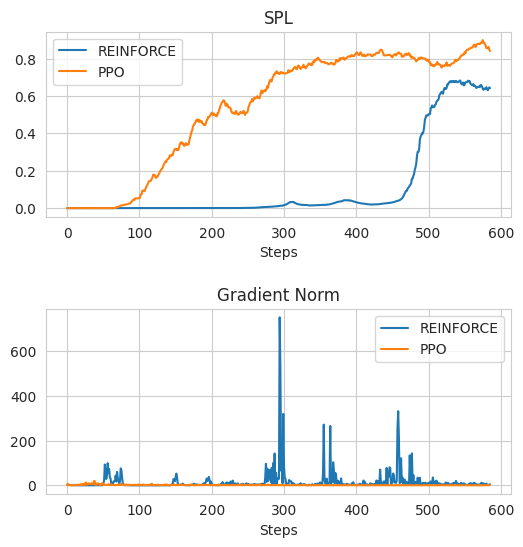

In [50]:


fig, axes = plt.subplots(2, 1, figsize=(6, 6))
plt.subplots_adjust(hspace=0.5)
plt.axes(axes[0])
plt.plot(reinforce_logs['metrics/spl'], label="REINFORCE")
plt.plot(ppo_logs['metrics/spl'], label="PPO")
plt.title("SPL")
plt.xlabel("Steps")
plt.legend()


plt.axes(axes[1])
plt.plot(reinforce_logs['learner/grad_norm'], label="REINFORCE")
plt.plot(ppo_logs['learner/grad_norm'], label="PPO")
plt.title("Gradient Norm")
plt.xlabel("Steps")
plt.legend()

### **Question** (10 pts)
1. What is the difference in the performance of REINFORCE and PPO? *(observe)*
2. What do you think is the reasons for the difference? *(hypothesize)*

__Answer:__

1. PPO outperforms REINFORCE significantly. It reaches high SPL quickly and maintains it, while REINFORCE stays flat for most of the time and only starts improving after ~480 steps. Even then, PPO still has better performance overall.

2. REINFORCE has much higher and unstable gradient norms, which can make training noisier and slower. PPO has smoother gradient updates, probably due to its clipped objective and advantage estimation (GAE), making it more sample-efficient and stable.